# CSCI 191T- Machine Learning 

## A Simple Convultion Neural Network to Recognize Hand-Written Digits With sklearn and TensorFlow

In this Notebook I will be Creating a simple Convultion nueral Network to recognize hand-written Digits from images. I will be using the MNIST dataset found on Kaggle to train and test my NN. This NN is consisting of 5 hidden layers.

1. Convultion Layer : Creates a layer with 32 filters which are basically like weights or neurons that can be used to identify and differenciate between diffent images

2. Max pool layer : This layer pools data from surrounding pixels and get an average value for them. This can be used to combine surrounding pixels to reduce the dimentionality of the image we are using

3. Convultion Layer : This convultion layer has 64 filters instead of the 32 we used earlier in the 1st layer. This can capture more details wich is crusial as we have reduced the pixel cound by combining neighbours to form a single pixel
4. Max pool layer : Another max Pool layer to reduce the dimentionality further
5. Dense Layer: connects with imputs from previous neurons in layers behind it. Insted of a densely connected layer we can also use a fully connected layer

apart from the hidden layers decibed above I have also used 3 other layers in this NN. 
1. An input layer that takes in the 28*28 pixel image data
2. A dropout layer to make the learning process more effective.
3. A logistic Layer: this is a layer of logistic regression that has access to neurons trained in the previous layers and funtions simillar to the logistic regression we are familliar with. this takes all prior neurons as inputs and give the probabilities that each given input belongs to each class in our Network

### Pre-Processing the Data

In [1]:
#Import Necessary packages
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import numpy as np
from skimage import data,transform, color
import tensorflow as tf
import time
import pandas as pd

In [2]:
raw_data = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
target = raw_data['label']
train = raw_data.drop(['label'],axis =1)


train = np.array(train).reshape((-1, 1, 28, 28))
test = np.array(test).reshape((-1, 1, 28, 28))



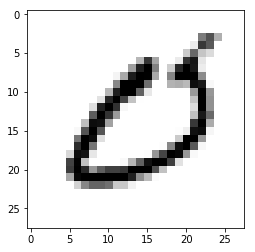

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [4]:
plt.imshow(train[1729][0], cmap=cm.binary) # draw the picture
plt.show()

In [52]:
def cnn_model_fn(features, labels, mode):
    with tf.device('/device:GPU:1'):
        input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
        pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
        dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
        dropout = tf.layers.dropout(inputs=dense, rate=0.2, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
        logits = tf.layers.dense(inputs=dropout, units=10)

        predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

        if mode == tf.estimator.ModeKeys.PREDICT:
            return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

      # Calculate Loss (for both TRAIN and EVAL modes)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

      # Configure the Training Op (for TRAIN mode)
        if mode == tf.estimator.ModeKeys.TRAIN:
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005)
            train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
            return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

      # Add evaluation metrics (for EVAL mode)
        eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)
  

In [56]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    with tf.device('/device:GPU:0'):
        dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

        # Shuffle, repeat, and batch the examples.
        dataset = dataset.shuffle(1000).repeat().batch(batch_size)

        # Return the read end of the pipeline.
        return dataset.make_one_shot_iterator().get_next()
    
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_modelnew")
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=50)

arr = np.asarray(target)
resized_images = np.asarray(train,dtype=np.float32)
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':resized_images},
    y=arr,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

mnist_classifier.train(input_fn=train_input_fn)


# Evaluate the model and print results
test_labels_dic = np.asarray(target)
test_images = np.asarray(train,dtype=np.float32)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':test_images},
    y=test_labels_dic,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_modelnew\model.ckpt-104160
INFO:tensorflow:Saving checkpoints for 104161 into /tmp/mnist_convnet_modelnew\model.ckpt.
INFO:tensorflow:loss = 6.65447e-06, step = 104161
INFO:tensorflow:global_step/sec: 4.53601
INFO:tensorflow:loss = 2.13991e-05, step = 104261 (22.047 sec)
INFO:tensorflow:global_step/sec: 4.58445
INFO:tensorflow:loss = 8.29254e-05, step = 104361 (21.813 sec)
INFO:tensorflow:global_step/sec: 4.57152
INFO:tensorflow:loss = 7.17545e-05, step = 104461 (21.875 sec)
INFO:tensorflow:global_step/sec: 4.67094
INFO:tensorflow:loss = 3.62332e-06, step = 104561 (21.409 sec)
INFO:tensorflow:global_step/sec: 4.641
INFO:tensorflow:loss = 1.84377e-05, step = 104661 (21.547 sec)
INFO:tensorflow:global_step/sec: 4.60534
INFO:tensorflow:loss = 9.70344e-07, step = 104761 (22.067 sec)
INFO:tensorflow:global_step/sec: 4

INFO:tensorflow:global_step/sec: 4.60534
INFO:tensorflow:loss = 2.13547e-05, step = 111661 (21.714 sec)
INFO:tensorflow:global_step/sec: 4.66394
INFO:tensorflow:loss = 1.5318e-06, step = 111761 (21.441 sec)
INFO:tensorflow:global_step/sec: 4.65454
INFO:tensorflow:loss = 8.20028e-06, step = 111861 (21.484 sec)
INFO:tensorflow:global_step/sec: 4.65386
INFO:tensorflow:loss = 1.22785e-07, step = 111961 (21.863 sec)
INFO:tensorflow:global_step/sec: 4.3853
INFO:tensorflow:loss = 3.53775e-06, step = 112061 (22.428 sec)
INFO:tensorflow:global_step/sec: 4.47866
INFO:tensorflow:loss = 0.000245473, step = 112161 (22.329 sec)
INFO:tensorflow:global_step/sec: 4.58039
INFO:tensorflow:loss = 2.47691e-06, step = 112261 (21.831 sec)
INFO:tensorflow:global_step/sec: 4.70072
INFO:tensorflow:loss = 1.1788e-05, step = 112361 (21.274 sec)
INFO:tensorflow:Saving checkpoints for 112399 into /tmp/mnist_convnet_modelnew\model.ckpt.
INFO:tensorflow:global_step/sec: 4.39658
INFO:tensorflow:loss = 7.7164e-06, step

INFO:tensorflow:global_step/sec: 4.55317
INFO:tensorflow:loss = 2.65816e-06, step = 119361 (21.962 sec)
INFO:tensorflow:global_step/sec: 4.78883
INFO:tensorflow:loss = 0.00984263, step = 119461 (20.882 sec)
INFO:tensorflow:global_step/sec: 4.84175
INFO:tensorflow:loss = 3.40899e-06, step = 119561 (20.654 sec)
INFO:tensorflow:global_step/sec: 4.86759
INFO:tensorflow:loss = 0.000407662, step = 119661 (20.544 sec)
INFO:tensorflow:global_step/sec: 4.8308
INFO:tensorflow:loss = 2.64501e-06, step = 119761 (21.354 sec)
INFO:tensorflow:global_step/sec: 4.73815
INFO:tensorflow:loss = 7.46601e-06, step = 119861 (20.452 sec)
INFO:tensorflow:global_step/sec: 4.88229
INFO:tensorflow:loss = 8.91517e-06, step = 119961 (20.482 sec)
INFO:tensorflow:global_step/sec: 4.86873
INFO:tensorflow:loss = 2.05745e-06, step = 120061 (20.539 sec)
INFO:tensorflow:global_step/sec: 4.89014
INFO:tensorflow:loss = 2.85232e-06, step = 120161 (20.449 sec)
INFO:tensorflow:global_step/sec: 4.88408
INFO:tensorflow:loss = 2.

INFO:tensorflow:loss = 1.26903e-05, step = 126961 (19.813 sec)
INFO:tensorflow:global_step/sec: 5.04416
INFO:tensorflow:loss = 1.19454e-05, step = 127061 (19.947 sec)
INFO:tensorflow:global_step/sec: 5.01503
INFO:tensorflow:loss = 0.000203379, step = 127161 (19.818 sec)
INFO:tensorflow:global_step/sec: 5.04039
INFO:tensorflow:loss = 0.000458091, step = 127261 (19.840 sec)
INFO:tensorflow:global_step/sec: 5.04098
INFO:tensorflow:loss = 8.92249e-06, step = 127361 (19.837 sec)
INFO:tensorflow:global_step/sec: 5.04493
INFO:tensorflow:loss = 4.65554e-06, step = 127461 (19.823 sec)
INFO:tensorflow:global_step/sec: 5.04588
INFO:tensorflow:loss = 7.13838e-06, step = 127561 (19.817 sec)
INFO:tensorflow:global_step/sec: 5.02201
INFO:tensorflow:loss = 0.000206348, step = 127661 (19.912 sec)
INFO:tensorflow:global_step/sec: 5.01867
INFO:tensorflow:loss = 0.000696377, step = 127761 (20.047 sec)
INFO:tensorflow:global_step/sec: 4.96334
INFO:tensorflow:loss = 3.74114e-05, step = 127861 (20.027 sec)
I

INFO:tensorflow:global_step/sec: 4.29584
INFO:tensorflow:loss = 4.70822e-05, step = 134561 (23.278 sec)
INFO:tensorflow:global_step/sec: 4.36046
INFO:tensorflow:loss = 9.56443e-06, step = 134661 (22.933 sec)
INFO:tensorflow:global_step/sec: 4.54656
INFO:tensorflow:loss = 7.06906e-07, step = 134761 (22.115 sec)
INFO:tensorflow:global_step/sec: 4.30835
INFO:tensorflow:loss = 9.41752e-08, step = 134861 (23.091 sec)
INFO:tensorflow:global_step/sec: 4.30938
INFO:tensorflow:loss = 6.78423e-05, step = 134961 (23.205 sec)
INFO:tensorflow:global_step/sec: 4.3222
INFO:tensorflow:loss = 0.000743587, step = 135061 (23.136 sec)
INFO:tensorflow:global_step/sec: 4.35006
INFO:tensorflow:loss = 0.000246935, step = 135161 (22.989 sec)
INFO:tensorflow:global_step/sec: 4.45698
INFO:tensorflow:loss = 2.4365e-06, step = 135261 (22.436 sec)
INFO:tensorflow:global_step/sec: 4.42123
INFO:tensorflow:loss = 1.04425e-06, step = 135361 (23.003 sec)
INFO:tensorflow:global_step/sec: 4.34684
INFO:tensorflow:loss = 3.

INFO:tensorflow:loss = 4.0039e-06, step = 142161 (23.670 sec)
INFO:tensorflow:global_step/sec: 4.21378
INFO:tensorflow:loss = 3.21865e-08, step = 142261 (23.731 sec)
INFO:tensorflow:global_step/sec: 4.23531
INFO:tensorflow:loss = 7.04471e-06, step = 142361 (23.611 sec)
INFO:tensorflow:global_step/sec: 4.20182
INFO:tensorflow:loss = 0.000170125, step = 142461 (24.169 sec)
INFO:tensorflow:global_step/sec: 4.24979
INFO:tensorflow:loss = 1.10264e-06, step = 142561 (23.161 sec)
INFO:tensorflow:global_step/sec: 4.26151
INFO:tensorflow:loss = 0.000880571, step = 142661 (23.466 sec)
INFO:tensorflow:global_step/sec: 4.33087
INFO:tensorflow:loss = 2.61161e-06, step = 142761 (23.091 sec)
INFO:tensorflow:global_step/sec: 4.2476
INFO:tensorflow:loss = 4.68903e-06, step = 142861 (23.542 sec)
INFO:tensorflow:global_step/sec: 4.28069
INFO:tensorflow:loss = 3.76699e-07, step = 142961 (23.360 sec)
INFO:tensorflow:global_step/sec: 4.23692
INFO:tensorflow:loss = 4.19716e-05, step = 143061 (23.972 sec)
INF

INFO:tensorflow:global_step/sec: 3.96534
INFO:tensorflow:loss = 1.70652e-05, step = 149861 (25.218 sec)
INFO:tensorflow:global_step/sec: 4.01668
INFO:tensorflow:loss = 1.46027e-06, step = 149961 (24.897 sec)
INFO:tensorflow:global_step/sec: 4.02559
INFO:tensorflow:loss = 1.98995e-05, step = 150061 (24.842 sec)
INFO:tensorflow:global_step/sec: 4.05169
INFO:tensorflow:loss = 1.88521e-05, step = 150161 (25.048 sec)
INFO:tensorflow:global_step/sec: 4.10128
INFO:tensorflow:loss = 0.0017944, step = 150261 (24.014 sec)
INFO:tensorflow:global_step/sec: 4.05867
INFO:tensorflow:loss = 1.48888e-06, step = 150361 (24.638 sec)
INFO:tensorflow:global_step/sec: 4.07867
INFO:tensorflow:loss = 1.68862e-05, step = 150461 (24.518 sec)
INFO:tensorflow:global_step/sec: 3.98118
INFO:tensorflow:loss = 2.06015e-05, step = 150561 (25.118 sec)
INFO:tensorflow:global_step/sec: 4.13099
INFO:tensorflow:loss = 8.25522e-06, step = 150661 (24.560 sec)
INFO:tensorflow:global_step/sec: 3.98913
INFO:tensorflow:loss = 1.

INFO:tensorflow:loss = 1.54584e-05, step = 157461 (24.299 sec)
INFO:tensorflow:global_step/sec: 4.28755
INFO:tensorflow:loss = 0.000409349, step = 157561 (23.323 sec)
INFO:tensorflow:global_step/sec: 4.12504
INFO:tensorflow:loss = 2.26497e-08, step = 157661 (24.242 sec)
INFO:tensorflow:global_step/sec: 4.245
INFO:tensorflow:loss = 0.000326933, step = 157761 (23.557 sec)
INFO:tensorflow:global_step/sec: 4.20111
INFO:tensorflow:loss = 1.01681e-06, step = 157861 (24.197 sec)
INFO:tensorflow:global_step/sec: 4.11759
INFO:tensorflow:loss = 4.57686e-06, step = 157961 (23.893 sec)
INFO:tensorflow:global_step/sec: 4.13552
INFO:tensorflow:loss = 0.000285831, step = 158061 (24.181 sec)
INFO:tensorflow:global_step/sec: 4.12902
INFO:tensorflow:loss = 1.04663e-06, step = 158161 (24.219 sec)
INFO:tensorflow:global_step/sec: 4.25171
INFO:tensorflow:loss = 4.84231e-06, step = 158261 (23.520 sec)
INFO:tensorflow:global_step/sec: 4.26101
INFO:tensorflow:loss = 5.27993e-06, step = 158361 (23.469 sec)
INF

INFO:tensorflow:global_step/sec: 4.18123
INFO:tensorflow:loss = 2.24993e-05, step = 165161 (24.317 sec)
INFO:tensorflow:global_step/sec: 4.02248
INFO:tensorflow:loss = 2.55326e-06, step = 165261 (24.460 sec)
INFO:tensorflow:global_step/sec: 3.96234
INFO:tensorflow:loss = 3.85735e-06, step = 165361 (25.238 sec)
INFO:tensorflow:global_step/sec: 4.07736
INFO:tensorflow:loss = 4.29539e-06, step = 165461 (24.525 sec)
INFO:tensorflow:global_step/sec: 4.0581
INFO:tensorflow:loss = 1.87914e-05, step = 165561 (24.643 sec)
INFO:tensorflow:global_step/sec: 4.1483
INFO:tensorflow:loss = 8.67712e-06, step = 165661 (24.231 sec)
INFO:tensorflow:global_step/sec: 3.98342
INFO:tensorflow:loss = 0.000105841, step = 165761 (24.979 sec)
INFO:tensorflow:global_step/sec: 4.1374
INFO:tensorflow:loss = 7.9307e-06, step = 165861 (24.170 sec)
INFO:tensorflow:global_step/sec: 3.99898
INFO:tensorflow:loss = 6.43208e-05, step = 165961 (25.007 sec)
INFO:tensorflow:Saving checkpoints for 166025 into /tmp/mnist_convne

INFO:tensorflow:global_step/sec: 3.99183
INFO:tensorflow:loss = 1.42295e-05, step = 172861 (25.052 sec)
INFO:tensorflow:global_step/sec: 4.15192
INFO:tensorflow:loss = 7.67693e-07, step = 172961 (24.440 sec)
INFO:tensorflow:global_step/sec: 4.13277
INFO:tensorflow:loss = 4.52901e-05, step = 173061 (23.842 sec)
INFO:tensorflow:global_step/sec: 4.01049
INFO:tensorflow:loss = 1.90841e-06, step = 173161 (24.935 sec)
INFO:tensorflow:global_step/sec: 4.139
INFO:tensorflow:loss = 2.52597e-06, step = 173261 (24.160 sec)
INFO:tensorflow:global_step/sec: 4.19999
INFO:tensorflow:loss = 4.63519e-06, step = 173361 (23.810 sec)
INFO:tensorflow:Saving checkpoints for 173415 into /tmp/mnist_convnet_modelnew\model.ckpt.
INFO:tensorflow:global_step/sec: 3.71957
INFO:tensorflow:loss = 1.26361e-07, step = 173461 (27.000 sec)
INFO:tensorflow:global_step/sec: 4.03038
INFO:tensorflow:loss = 0.000384385, step = 173561 (24.698 sec)
INFO:tensorflow:global_step/sec: 3.90188
INFO:tensorflow:loss = 1.03617e-05, st

INFO:tensorflow:loss = 1.08713e-06, step = 180461 (22.987 sec)
INFO:tensorflow:global_step/sec: 4.23753
INFO:tensorflow:loss = 8.94067e-08, step = 180561 (23.598 sec)
INFO:tensorflow:global_step/sec: 4.26199
INFO:tensorflow:loss = 0.00136812, step = 180661 (23.463 sec)
INFO:tensorflow:global_step/sec: 4.3161
INFO:tensorflow:loss = 8.07019e-07, step = 180761 (23.169 sec)
INFO:tensorflow:global_step/sec: 4.22209
INFO:tensorflow:loss = 0.00379892, step = 180861 (23.685 sec)
INFO:tensorflow:Saving checkpoints for 180901 into /tmp/mnist_convnet_modelnew\model.ckpt.
INFO:tensorflow:global_step/sec: 4.00436
INFO:tensorflow:loss = 5.79371e-05, step = 180961 (24.973 sec)
INFO:tensorflow:global_step/sec: 4.24649
INFO:tensorflow:loss = 6.66396e-06, step = 181061 (23.550 sec)
INFO:tensorflow:global_step/sec: 4.27611
INFO:tensorflow:loss = 5.62036e-06, step = 181161 (23.733 sec)
INFO:tensorflow:global_step/sec: 4.16664
INFO:tensorflow:loss = 2.36887e-05, step = 181261 (23.650 sec)
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 4.06722
INFO:tensorflow:loss = 3.5033e-06, step = 188161 (24.586 sec)
INFO:tensorflow:global_step/sec: 4.08611
INFO:tensorflow:loss = 0.00304686, step = 188261 (24.473 sec)
INFO:tensorflow:global_step/sec: 4.12786
INFO:tensorflow:loss = 1.49126e-06, step = 188361 (24.226 sec)
INFO:tensorflow:Saving checkpoints for 188387 into /tmp/mnist_convnet_modelnew\model.ckpt.
INFO:tensorflow:global_step/sec: 3.79092
INFO:tensorflow:loss = 1.49876e-05, step = 188461 (26.495 sec)
INFO:tensorflow:global_step/sec: 4.08329
INFO:tensorflow:loss = 1.52453e-05, step = 188561 (24.373 sec)
INFO:tensorflow:global_step/sec: 4.13028
INFO:tensorflow:loss = 5.80539e-07, step = 188661 (24.212 sec)
INFO:tensorflow:global_step/sec: 4.13923
INFO:tensorflow:loss = 7.71272e-07, step = 188761 (24.159 sec)
INFO:tensorflow:global_step/sec: 4.11939
INFO:tensorflow:loss = 8.76758e-06, step = 188861 (24.275 sec)
INFO:tensorflow:global_step/sec: 4.1508
INFO:tensorflow:loss = 1.83923e-06, ste

INFO:tensorflow:global_step/sec: 4.09636
INFO:tensorflow:loss = 4.60141e-07, step = 195861 (24.412 sec)
INFO:tensorflow:Saving checkpoints for 195908 into /tmp/mnist_convnet_modelnew\model.ckpt.
INFO:tensorflow:global_step/sec: 3.9377
INFO:tensorflow:loss = 1.07514e-05, step = 195961 (25.396 sec)
INFO:tensorflow:global_step/sec: 4.23044
INFO:tensorflow:loss = 3.35455e-05, step = 196061 (23.753 sec)
INFO:tensorflow:global_step/sec: 4.08719
INFO:tensorflow:loss = 4.32726e-07, step = 196161 (24.352 sec)
INFO:tensorflow:global_step/sec: 4.21548
INFO:tensorflow:loss = 1.20807e-05, step = 196261 (23.723 sec)
INFO:tensorflow:global_step/sec: 4.04318
INFO:tensorflow:loss = 2.73926e-06, step = 196361 (24.732 sec)
INFO:tensorflow:global_step/sec: 4.11674
INFO:tensorflow:loss = 1.70715e-05, step = 196461 (24.291 sec)
INFO:tensorflow:global_step/sec: 4.18623
INFO:tensorflow:loss = 2.43906e-05, step = 196561 (24.007 sec)
INFO:tensorflow:global_step/sec: 4.14307
INFO:tensorflow:loss = 4.26073e-05, s

INFO:tensorflow:global_step/sec: 4.01206
INFO:tensorflow:loss = 5.55124e-05, step = 203461 (24.925 sec)
INFO:tensorflow:global_step/sec: 4.33159
INFO:tensorflow:loss = 0.00121058, step = 203561 (23.086 sec)
INFO:tensorflow:global_step/sec: 4.30419
INFO:tensorflow:loss = 1.38991e-06, step = 203661 (23.353 sec)
INFO:tensorflow:global_step/sec: 4.26668
INFO:tensorflow:loss = 1.3041e-06, step = 203761 (23.318 sec)
INFO:tensorflow:global_step/sec: 4.25261
INFO:tensorflow:loss = 2.26129e-06, step = 203861 (23.514 sec)
INFO:tensorflow:global_step/sec: 4.338
INFO:tensorflow:loss = 0.000213496, step = 203961 (23.052 sec)
INFO:tensorflow:global_step/sec: 4.30304
INFO:tensorflow:loss = 3.32591e-07, step = 204061 (23.240 sec)
INFO:tensorflow:global_step/sec: 4.28576
INFO:tensorflow:loss = 6.61897e-06, step = 204161 (23.333 sec)
INFO:tensorflow:global_step/sec: 4.23964
INFO:tensorflow:loss = 4.62529e-07, step = 204261 (23.960 sec)
INFO:tensorflow:global_step/sec: 4.19028
INFO:tensorflow:loss = 1.23

KeyboardInterrupt: 

In [54]:
test_labels_dic = np.asarray(target)
test_images = np.asarray(train,dtype=np.float32)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':test_images},
    y=test_labels_dic,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-03-21-00:32:30
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_modelnew\model.ckpt-104160
INFO:tensorflow:Finished evaluation at 2018-03-21-00:33:01
INFO:tensorflow:Saving dict for global step 104160: accuracy = 1.0, global_step = 104160, loss = 3.38275e-06
{'accuracy': 1.0, 'loss': 3.3827514e-06, 'global_step': 104160}


In [ ]:
plt.imshow(test[1729][0], cmap=cm.binary) # draw the picture
plt.show()
predicted_class =  []
input_fn = tf.estimator.inputs.numpy_input_fn(x={'x': test},num_epochs=1,
    shuffle=False)
for single_prediction in mnist_classifier.predict(input_fn):
    #print(single_prediction)
    predicted_class.append( single_prediction['classes'])
  
ids = np.array([x for x in range(1,28001)])
submission = pd.DataFrame({
        "ImageID": ids,
        "Label": predicted_class
    })
##print(submission)
submission.to_csv('200k steps.csv', encoding='utf-8', index=False)


# CNN Model 2 with 3 conlultion Layers

In [66]:
def cnn_model_fn2(features, labels, mode):
    with tf.device('/device:GPU:1'):
        input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        conv3 = tf.layers.conv2d(inputs=pool2,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
  # Dense Layer
        shaped = tf.reshape(conv3, [-1, 7 * 7 * 64])
        dense = tf.layers.dense(inputs=shaped, units=1024, activation=tf.nn.relu)
        dropout = tf.layers.dropout(inputs=dense, rate=0.2, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
        logits = tf.layers.dense(inputs=dropout, units=10)

        predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

        if mode == tf.estimator.ModeKeys.PREDICT:
            return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

      # Calculate Loss (for both TRAIN and EVAL modes)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

      # Configure the Training Op (for TRAIN mode)
        if mode == tf.estimator.ModeKeys.TRAIN:
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005)
            train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
            return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

      # Add evaluation metrics (for EVAL mode)
        eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)
  

In [74]:
def train_input_fn2(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    with tf.device('/device:GPU:1'):
        dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

        # Shuffle, repeat, and batch the examples.
        dataset = dataset.shuffle(1000).repeat().batch(batch_size)

        # Return the read end of the pipeline.
        return dataset.make_one_shot_iterator().get_next()
    
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn2, model_dir="/tmp/mnist_convnet_model2")
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=50)

arr = np.asarray(target)
resized_images = np.asarray(train,dtype=np.float32)
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':resized_images},
    y=arr,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

mnist_classifier.train(input_fn=train_input_fn)


# Evaluate the model and print results
test_labels_dic = np.asarray(target)
test_images = np.asarray(train,dtype=np.float32)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':test_images},
    y=test_labels_dic,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model2\model.ckpt-147743
INFO:tensorflow:Saving checkpoints for 147744 into /tmp/mnist_convnet_model2\model.ckpt.
INFO:tensorflow:loss = 1.38015e-05, step = 147744
INFO:tensorflow:global_step/sec: 3.4835
INFO:tensorflow:loss = 5.04217e-06, step = 147844 (28.709 sec)
INFO:tensorflow:global_step/sec: 3.47824
INFO:tensorflow:loss = 2.55107e-05, step = 147944 (28.749 sec)
INFO:tensorflow:global_step/sec: 3.49466
INFO:tensorflow:loss = 3.47679e-06, step = 148044 (28.616 sec)
INFO:tensorflow:global_step/sec: 3.51039
INFO:tensorflow:loss = 1.5628e-06, step = 148144 (28.487 sec)
INFO:tensorflow:global_step/sec: 3.5409
INFO:tensorflow:loss = 4.87561e-07, step = 148244 (28.605 sec)
INFO:tensorflow:global_step/sec: 3.47579
INFO:tensorflow:loss = 0.000140746, step = 148344 (28.406 sec)
INFO:tensorflow:global_step/sec: 3.5475

INFO:tensorflow:loss = 9.30996e-07, step = 155144 (28.076 sec)
INFO:tensorflow:global_step/sec: 3.51117
INFO:tensorflow:loss = 2.02656e-08, step = 155244 (28.840 sec)
INFO:tensorflow:global_step/sec: 3.548
INFO:tensorflow:loss = 1.63746e-05, step = 155344 (27.825 sec)
INFO:tensorflow:global_step/sec: 3.30786
INFO:tensorflow:loss = 2.79758e-06, step = 155444 (30.232 sec)
INFO:tensorflow:global_step/sec: 3.6006
INFO:tensorflow:loss = 2.12184e-06, step = 155544 (27.774 sec)
INFO:tensorflow:global_step/sec: 3.5703
INFO:tensorflow:loss = 3.37359e-07, step = 155644 (28.008 sec)
INFO:tensorflow:global_step/sec: 3.51485
INFO:tensorflow:loss = 1.37684e-06, step = 155744 (28.807 sec)
INFO:tensorflow:global_step/sec: 3.33523
INFO:tensorflow:loss = 1.02152e-05, step = 155844 (29.627 sec)
INFO:tensorflow:global_step/sec: 3.47617
INFO:tensorflow:loss = 7.39953e-06, step = 155944 (28.767 sec)
INFO:tensorflow:global_step/sec: 3.50423
INFO:tensorflow:loss = 1.45763e-05, step = 156044 (28.537 sec)
INFO:

INFO:tensorflow:global_step/sec: 3.52135
INFO:tensorflow:loss = 1.905e-05, step = 162744 (28.269 sec)
INFO:tensorflow:global_step/sec: 3.51083
INFO:tensorflow:loss = 1.66052e-06, step = 162844 (28.483 sec)
INFO:tensorflow:global_step/sec: 3.528
INFO:tensorflow:loss = 3.90456e-06, step = 162944 (28.344 sec)
INFO:tensorflow:global_step/sec: 3.51481
INFO:tensorflow:loss = 4.70871e-07, step = 163044 (28.452 sec)
INFO:tensorflow:global_step/sec: 3.5136
INFO:tensorflow:loss = 1.59498e-06, step = 163144 (28.817 sec)
INFO:tensorflow:global_step/sec: 3.53055
INFO:tensorflow:loss = 6.91412e-08, step = 163244 (27.968 sec)
INFO:tensorflow:global_step/sec: 3.56302
INFO:tensorflow:loss = 8.7259e-06, step = 163344 (28.067 sec)
INFO:tensorflow:global_step/sec: 3.59012
INFO:tensorflow:loss = 4.99475e-07, step = 163444 (27.853 sec)
INFO:tensorflow:global_step/sec: 3.58197
INFO:tensorflow:loss = 7.79813e-06, step = 163544 (27.918 sec)
INFO:tensorflow:global_step/sec: 3.56536
INFO:tensorflow:loss = 7.4041

INFO:tensorflow:global_step/sec: 3.61119
INFO:tensorflow:loss = 6.67571e-08, step = 170444 (27.692 sec)
INFO:tensorflow:global_step/sec: 3.60272
INFO:tensorflow:loss = 7.93833e-06, step = 170544 (28.107 sec)
INFO:tensorflow:global_step/sec: 3.56059
INFO:tensorflow:loss = 2.27675e-06, step = 170644 (27.735 sec)
INFO:tensorflow:global_step/sec: 3.61559
INFO:tensorflow:loss = 8.99254e-06, step = 170744 (27.659 sec)
INFO:tensorflow:global_step/sec: 3.60032
INFO:tensorflow:loss = 7.62916e-07, step = 170844 (27.775 sec)
INFO:tensorflow:global_step/sec: 3.6306
INFO:tensorflow:loss = 7.44068e-06, step = 170944 (27.543 sec)
INFO:tensorflow:Saving checkpoints for 171022 into /tmp/mnist_convnet_model2\model.ckpt.
INFO:tensorflow:global_step/sec: 3.48325
INFO:tensorflow:loss = 4.98803e-05, step = 171044 (28.709 sec)
INFO:tensorflow:global_step/sec: 3.60431
INFO:tensorflow:loss = 6.63764e-05, step = 171144 (27.745 sec)
INFO:tensorflow:global_step/sec: 3.56358
INFO:tensorflow:loss = 4.21197e-06, ste

INFO:tensorflow:global_step/sec: 3.50315
INFO:tensorflow:loss = 7.93945e-06, step = 178044 (28.180 sec)
INFO:tensorflow:global_step/sec: 3.55667
INFO:tensorflow:loss = 1.95502e-07, step = 178144 (28.117 sec)
INFO:tensorflow:global_step/sec: 3.55312
INFO:tensorflow:loss = 1.95115e-05, step = 178244 (28.144 sec)
INFO:tensorflow:global_step/sec: 3.56416
INFO:tensorflow:loss = 9.07168e-07, step = 178344 (28.057 sec)
INFO:tensorflow:global_step/sec: 3.5645
INFO:tensorflow:loss = 2.65836e-07, step = 178444 (28.440 sec)
INFO:tensorflow:global_step/sec: 3.55599
INFO:tensorflow:loss = 6.99557e-06, step = 178544 (27.736 sec)
INFO:tensorflow:global_step/sec: 3.52892
INFO:tensorflow:loss = 4.58202e-06, step = 178644 (28.338 sec)
INFO:tensorflow:global_step/sec: 3.6083
INFO:tensorflow:loss = 1.24809e-06, step = 178744 (27.713 sec)
INFO:tensorflow:global_step/sec: 3.61003
INFO:tensorflow:loss = 2.73257e-05, step = 178844 (27.702 sec)
INFO:tensorflow:global_step/sec: 3.60579
INFO:tensorflow:loss = 1.

INFO:tensorflow:loss = 3.77273e-06, step = 185644 (28.277 sec)
INFO:tensorflow:global_step/sec: 3.62432
INFO:tensorflow:loss = 1.04444e-05, step = 185744 (27.591 sec)
INFO:tensorflow:global_step/sec: 3.62452
INFO:tensorflow:loss = 0.000140554, step = 185844 (27.590 sec)
INFO:tensorflow:global_step/sec: 3.61208
INFO:tensorflow:loss = 1.89644e-06, step = 185944 (28.044 sec)
INFO:tensorflow:global_step/sec: 3.58064
INFO:tensorflow:loss = 5.27678e-06, step = 186044 (27.569 sec)
INFO:tensorflow:Saving checkpoints for 186111 into /tmp/mnist_convnet_model2\model.ckpt.
INFO:tensorflow:global_step/sec: 3.45235
INFO:tensorflow:loss = 8.3922e-07, step = 186144 (28.965 sec)
INFO:tensorflow:global_step/sec: 3.56491
INFO:tensorflow:loss = 4.22168e-06, step = 186244 (28.052 sec)
INFO:tensorflow:global_step/sec: 3.56815
INFO:tensorflow:loss = 0.000397892, step = 186344 (28.025 sec)
INFO:tensorflow:global_step/sec: 3.54502
INFO:tensorflow:loss = 1.27554e-07, step = 186444 (28.562 sec)
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 3.7859
INFO:tensorflow:loss = 2.00025e-06, step = 193244 (26.414 sec)
INFO:tensorflow:global_step/sec: 3.79206
INFO:tensorflow:loss = 6.25841e-07, step = 193344 (26.734 sec)
INFO:tensorflow:global_step/sec: 3.74002
INFO:tensorflow:loss = 9.09557e-07, step = 193444 (26.375 sec)
INFO:tensorflow:global_step/sec: 3.79701
INFO:tensorflow:loss = 1.32201e-06, step = 193544 (26.337 sec)
INFO:tensorflow:global_step/sec: 3.787
INFO:tensorflow:loss = 1.18282e-05, step = 193644 (26.406 sec)
INFO:tensorflow:global_step/sec: 3.77752
INFO:tensorflow:loss = 4.54183e-07, step = 193744 (26.472 sec)
INFO:tensorflow:global_step/sec: 3.78573
INFO:tensorflow:loss = 7.9661e-06, step = 193844 (26.783 sec)
INFO:tensorflow:global_step/sec: 3.73197
INFO:tensorflow:loss = 1.94463e-05, step = 193944 (26.429 sec)
INFO:tensorflow:global_step/sec: 3.78807
INFO:tensorflow:loss = 8.58306e-08, step = 194044 (26.398 sec)
INFO:tensorflow:global_step/sec: 3.79602
INFO:tensorflow:loss = 6.87

INFO:tensorflow:global_step/sec: 3.6962
INFO:tensorflow:loss = 1.32672e-06, step = 200944 (26.701 sec)
INFO:tensorflow:global_step/sec: 3.73706
INFO:tensorflow:loss = 2.7309e-06, step = 201044 (26.759 sec)
INFO:tensorflow:global_step/sec: 3.74249
INFO:tensorflow:loss = 3.18862e-06, step = 201144 (26.721 sec)
INFO:tensorflow:global_step/sec: 3.74908
INFO:tensorflow:loss = 0.000372777, step = 201244 (26.672 sec)
INFO:tensorflow:global_step/sec: 3.72212
INFO:tensorflow:loss = 4.76837e-09, step = 201344 (26.996 sec)
INFO:tensorflow:global_step/sec: 3.76022
INFO:tensorflow:loss = 6.0677e-07, step = 201444 (26.465 sec)
INFO:tensorflow:global_step/sec: 3.77427
INFO:tensorflow:loss = 1.4793e-06, step = 201544 (26.495 sec)
INFO:tensorflow:global_step/sec: 3.71943
INFO:tensorflow:loss = 1.21949e-06, step = 201644 (26.886 sec)
INFO:tensorflow:Saving checkpoints for 201659 into /tmp/mnist_convnet_model2\model.ckpt.
INFO:tensorflow:global_step/sec: 3.58836
INFO:tensorflow:loss = 1.85966e-07, step =

INFO:tensorflow:global_step/sec: 3.77016
INFO:tensorflow:loss = 7.37892e-07, step = 208544 (26.524 sec)
INFO:tensorflow:global_step/sec: 3.78412
INFO:tensorflow:loss = 1.17419e-06, step = 208644 (26.426 sec)
INFO:tensorflow:global_step/sec: 3.77278
INFO:tensorflow:loss = 1.23888e-05, step = 208744 (26.506 sec)
INFO:tensorflow:global_step/sec: 3.78458
INFO:tensorflow:loss = 4.83564e-05, step = 208844 (26.774 sec)
INFO:tensorflow:global_step/sec: 3.73816
INFO:tensorflow:loss = 5.84125e-08, step = 208944 (26.400 sec)
INFO:tensorflow:global_step/sec: 3.79161
INFO:tensorflow:loss = 1.89767e-06, step = 209044 (26.374 sec)
INFO:tensorflow:global_step/sec: 3.77723
INFO:tensorflow:loss = 6.27026e-07, step = 209144 (26.475 sec)
INFO:tensorflow:global_step/sec: 3.77487
INFO:tensorflow:loss = 2.98023e-08, step = 209244 (26.490 sec)
INFO:tensorflow:global_step/sec: 3.77549
INFO:tensorflow:loss = 1.19209e-08, step = 209344 (26.859 sec)
INFO:tensorflow:global_step/sec: 3.73408
INFO:tensorflow:loss = 

INFO:tensorflow:loss = 6.96968e-06, step = 216144 (27.656 sec)
INFO:tensorflow:global_step/sec: 3.61023
INFO:tensorflow:loss = 0.000130056, step = 216244 (27.699 sec)
INFO:tensorflow:global_step/sec: 3.62247
INFO:tensorflow:loss = 4.10077e-07, step = 216344 (27.960 sec)
INFO:tensorflow:global_step/sec: 3.57522
INFO:tensorflow:loss = 5.57441e-06, step = 216444 (27.616 sec)
INFO:tensorflow:global_step/sec: 3.62814
INFO:tensorflow:loss = 4.60143e-07, step = 216544 (27.562 sec)
INFO:tensorflow:global_step/sec: 3.61755
INFO:tensorflow:loss = 3.30707e-05, step = 216644 (27.643 sec)
INFO:tensorflow:global_step/sec: 3.5227
INFO:tensorflow:loss = 1.10514e-05, step = 216744 (28.387 sec)
INFO:tensorflow:global_step/sec: 3.59975
INFO:tensorflow:loss = 5.67531e-06, step = 216844 (28.145 sec)
INFO:tensorflow:global_step/sec: 3.51194
INFO:tensorflow:loss = 5.81736e-07, step = 216944 (28.109 sec)
INFO:tensorflow:global_step/sec: 3.58521
INFO:tensorflow:loss = 2.48301e-06, step = 217044 (27.892 sec)
IN

INFO:tensorflow:Saving checkpoints for 223761 into /tmp/mnist_convnet_model2\model.ckpt.
INFO:tensorflow:global_step/sec: 3.43445
INFO:tensorflow:loss = 2.82026e-06, step = 223844 (28.762 sec)
INFO:tensorflow:global_step/sec: 3.60486
INFO:tensorflow:loss = 3.68353e-07, step = 223944 (27.740 sec)
INFO:tensorflow:global_step/sec: 3.61236
INFO:tensorflow:loss = 1.00263e-05, step = 224044 (27.683 sec)
INFO:tensorflow:global_step/sec: 3.59894
INFO:tensorflow:loss = 9.53673e-08, step = 224144 (27.786 sec)
INFO:tensorflow:global_step/sec: 3.60887
INFO:tensorflow:loss = 6.68453e-06, step = 224244 (28.072 sec)
INFO:tensorflow:global_step/sec: 3.5534
INFO:tensorflow:loss = 2.47701e-06, step = 224344 (27.780 sec)
INFO:tensorflow:global_step/sec: 3.61513
INFO:tensorflow:loss = 2.59036e-05, step = 224444 (27.661 sec)
INFO:tensorflow:global_step/sec: 3.60645
INFO:tensorflow:loss = 2.8014e-07, step = 224544 (27.728 sec)
INFO:tensorflow:global_step/sec: 3.53112
INFO:tensorflow:loss = 3.44732e-06, step

INFO:tensorflow:global_step/sec: 3.74973
INFO:tensorflow:loss = 7.35505e-07, step = 231444 (26.669 sec)
INFO:tensorflow:global_step/sec: 3.76534
INFO:tensorflow:loss = 6.87826e-07, step = 231544 (26.558 sec)
INFO:tensorflow:global_step/sec: 3.75468
INFO:tensorflow:loss = 2.48654e-06, step = 231644 (26.634 sec)
INFO:tensorflow:global_step/sec: 3.76855
INFO:tensorflow:loss = 1.20754e-06, step = 231744 (26.903 sec)
INFO:tensorflow:global_step/sec: 3.70566
INFO:tensorflow:loss = 4.45653e-06, step = 231844 (26.617 sec)
INFO:tensorflow:global_step/sec: 3.76263
INFO:tensorflow:loss = 1.41974e-06, step = 231944 (26.577 sec)
INFO:tensorflow:global_step/sec: 3.78194
INFO:tensorflow:loss = 4.93517e-07, step = 232044 (26.441 sec)
INFO:tensorflow:global_step/sec: 3.78427
INFO:tensorflow:loss = 1.25883e-06, step = 232144 (26.425 sec)
INFO:tensorflow:global_step/sec: 3.7761
INFO:tensorflow:loss = 2.24113e-07, step = 232244 (26.882 sec)
INFO:tensorflow:global_step/sec: 3.68558
INFO:tensorflow:loss = 0

KeyboardInterrupt: 

In [71]:
test = np.asarray(test,dtype=np.float32)
pred = mnist_classifier.predict(test[1729][0])
print(pred)

<generator object Estimator.predict at 0x0000026E0B53FB48>


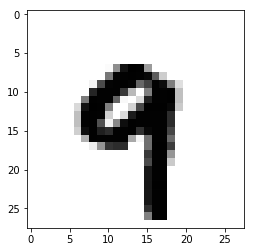

INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model2\model.ckpt-234694


In [75]:
plt.imshow(test[1729][0], cmap=cm.binary) # draw the picture
plt.show()
predicted_class =  []
input_fn = tf.estimator.inputs.numpy_input_fn(x={'x': test},num_epochs=1,
    shuffle=False)
for single_prediction in mnist_classifier.predict(input_fn):
    #print(single_prediction)
    predicted_class.append( single_prediction['classes'])
  
ids = np.array([x for x in range(1,28001)])
submission = pd.DataFrame({
        "ImageID": ids,
        "Label": predicted_class
    })
##print(submission)
submission.to_csv('NN2 236k steps.csv', encoding='utf-8', index=False)


# CNN Model 3 with 3 conlultion Layers

In [78]:
def cnn_model_fn3(features, labels, mode):
    with tf.device('/device:GPU:1'):
        input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        conv3 = tf.layers.conv2d(inputs=pool2,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
  # Dense Layer
        shaped = tf.reshape(conv3, [-1, 7 * 7 * 64])
        dense = tf.layers.dense(inputs=shaped, units=1024, activation=tf.nn.relu)
        dense2 = tf.layers.dense(inputs=dense, units=512, activation=tf.nn.relu)
        dropout = tf.layers.dropout(inputs=dense2, rate=0.2, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
        logits = tf.layers.dense(inputs=dropout, units=10)

        predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

        if mode == tf.estimator.ModeKeys.PREDICT:
            return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

      # Calculate Loss (for both TRAIN and EVAL modes)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

      # Configure the Training Op (for TRAIN mode)
        if mode == tf.estimator.ModeKeys.TRAIN:
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005)
            train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
            return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

      # Add evaluation metrics (for EVAL mode)
        eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)
  

In [ ]:
def train_input_fn3(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    with tf.device('/device:GPU:1'):
        dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

        # Shuffle, repeat, and batch the examples.
        dataset = dataset.shuffle(1000).repeat().batch(batch_size)

        # Return the read end of the pipeline.
        return dataset.make_one_shot_iterator().get_next()
    
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn2, model_dir="/tmp/mnist_convnet_model3.1")
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=50)

arr = np.asarray(target)
resized_images = np.asarray(train,dtype=np.float32)
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':resized_images/255},
    y=arr,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

mnist_classifier.train(input_fn=train_input_fn)


# Evaluate the model and print results
test_labels_dic = np.asarray(target)
test_images = np.asarray(train,dtype=np.float32)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':test_images},
    y=test_labels_dic,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model3.1\model.ckpt-126082
INFO:tensorflow:Saving checkpoints for 126083 into /tmp/mnist_convnet_model3.1\model.ckpt.
INFO:tensorflow:loss = 0.000791311, step = 126083
INFO:tensorflow:global_step/sec: 3.49513
INFO:tensorflow:loss = 0.00137896, step = 126183 (28.612 sec)
INFO:tensorflow:global_step/sec: 3.57066
INFO:tensorflow:loss = 0.000126556, step = 126283 (28.006 sec)
INFO:tensorflow:global_step/sec: 3.58912
INFO:tensorflow:loss = 0.000669301, step = 126383 (27.862 sec)
INFO:tensorflow:global_step/sec: 3.49255
INFO:tensorflow:loss = 0.000613731, step = 126483 (28.633 sec)
INFO:tensorflow:global_step/sec: 3.53736
INFO:tensorflow:loss = 0.00364165, step = 126583 (28.394 sec)
INFO:tensorflow:global_step/sec: 3.6028
INFO:tensorflow:loss = 0.000500843, step = 126683 (27.631 sec)
INFO:tensorflow:global_step/sec: 3.

INFO:tensorflow:loss = 9.06036e-05, step = 133483 (31.524 sec)
INFO:tensorflow:global_step/sec: 3.1693
INFO:tensorflow:loss = 7.72108e-05, step = 133583 (31.925 sec)
INFO:tensorflow:global_step/sec: 3.18066
INFO:tensorflow:loss = 0.000127222, step = 133683 (31.067 sec)
INFO:tensorflow:global_step/sec: 3.26573
INFO:tensorflow:loss = 0.00014652, step = 133783 (30.622 sec)
INFO:tensorflow:Saving checkpoints for 133826 into /tmp/mnist_convnet_model3.1\model.ckpt.
INFO:tensorflow:global_step/sec: 3.15891
INFO:tensorflow:loss = 4.37646e-05, step = 133883 (31.656 sec)
INFO:tensorflow:global_step/sec: 3.29367
INFO:tensorflow:loss = 0.00114853, step = 133983 (30.485 sec)
INFO:tensorflow:global_step/sec: 3.1597
INFO:tensorflow:loss = 0.00058327, step = 134083 (31.526 sec)
INFO:tensorflow:global_step/sec: 3.16327
INFO:tensorflow:loss = 0.000220073, step = 134183 (31.613 sec)
INFO:tensorflow:global_step/sec: 3.22066
INFO:tensorflow:loss = 0.00025956, step = 134283 (31.049 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 3.46526
INFO:tensorflow:loss = 0.0049697, step = 141083 (28.857 sec)
INFO:tensorflow:global_step/sec: 3.39913
INFO:tensorflow:loss = 4.78731e-05, step = 141183 (29.419 sec)
INFO:tensorflow:global_step/sec: 3.44207
INFO:tensorflow:loss = 0.000290175, step = 141283 (29.414 sec)
INFO:tensorflow:global_step/sec: 3.44258
INFO:tensorflow:loss = 2.77852e-05, step = 141383 (28.687 sec)
INFO:tensorflow:global_step/sec: 3.39054
INFO:tensorflow:loss = 0.000207866, step = 141483 (29.494 sec)
INFO:tensorflow:global_step/sec: 3.39733
INFO:tensorflow:loss = 5.2682e-05, step = 141583 (29.435 sec)
INFO:tensorflow:global_step/sec: 3.49138
INFO:tensorflow:loss = 0.000401834, step = 141683 (28.642 sec)
INFO:tensorflow:Saving checkpoints for 141699 into /tmp/mnist_convnet_model3.1\model.ckpt.
INFO:tensorflow:global_step/sec: 3.22207
INFO:tensorflow:loss = 4.33924e-05, step = 141783 (31.036 sec)
INFO:tensorflow:global_step/sec: 3.35955
INFO:tensorflow:loss = 0.000157583, ste

INFO:tensorflow:global_step/sec: 3.13288
INFO:tensorflow:loss = 0.000180727, step = 148683 (31.919 sec)
INFO:tensorflow:global_step/sec: 3.21981
INFO:tensorflow:loss = 0.000325178, step = 148783 (31.058 sec)
INFO:tensorflow:global_step/sec: 3.41453
INFO:tensorflow:loss = 0.00014124, step = 148883 (29.410 sec)
INFO:tensorflow:global_step/sec: 3.3237
INFO:tensorflow:loss = 3.09734e-05, step = 148983 (29.965 sec)
INFO:tensorflow:global_step/sec: 3.27994
INFO:tensorflow:loss = 0.000185668, step = 149083 (30.487 sec)
INFO:tensorflow:global_step/sec: 3.2399
INFO:tensorflow:loss = 3.70489e-06, step = 149183 (30.866 sec)
INFO:tensorflow:global_step/sec: 3.34471
INFO:tensorflow:loss = 0.00145756, step = 149283 (30.271 sec)
INFO:tensorflow:global_step/sec: 3.18859
INFO:tensorflow:loss = 2.18315e-05, step = 149383 (30.989 sec)
INFO:tensorflow:global_step/sec: 3.53541
INFO:tensorflow:loss = 9.3679e-05, step = 149483 (28.285 sec)
INFO:tensorflow:global_step/sec: 3.50514
INFO:tensorflow:loss = 0.000

INFO:tensorflow:global_step/sec: 3.4022
INFO:tensorflow:loss = 0.000107126, step = 156283 (29.748 sec)
INFO:tensorflow:global_step/sec: 3.37711
INFO:tensorflow:loss = 3.96249e-05, step = 156383 (29.256 sec)
INFO:tensorflow:global_step/sec: 3.45153
INFO:tensorflow:loss = 4.73401e-05, step = 156483 (28.973 sec)
INFO:tensorflow:global_step/sec: 3.38114
INFO:tensorflow:loss = 0.000173169, step = 156583 (29.575 sec)
INFO:tensorflow:global_step/sec: 3.40884
INFO:tensorflow:loss = 0.000309191, step = 156683 (29.335 sec)
INFO:tensorflow:global_step/sec: 3.35308
INFO:tensorflow:loss = 0.000359454, step = 156783 (30.190 sec)
INFO:tensorflow:global_step/sec: 3.34661
INFO:tensorflow:loss = 1.0894e-05, step = 156883 (29.514 sec)
INFO:tensorflow:global_step/sec: 3.43594
INFO:tensorflow:loss = 0.00211254, step = 156983 (29.105 sec)
INFO:tensorflow:global_step/sec: 3.40532
INFO:tensorflow:loss = 0.000244907, step = 157083 (29.365 sec)
INFO:tensorflow:global_step/sec: 3.4137
INFO:tensorflow:loss = 0.00

INFO:tensorflow:Saving checkpoints for 163946 into /tmp/mnist_convnet_model3.1\model.ckpt.
INFO:tensorflow:global_step/sec: 3.24955
INFO:tensorflow:loss = 0.000717026, step = 163983 (30.774 sec)
INFO:tensorflow:global_step/sec: 3.4059
INFO:tensorflow:loss = 3.11809e-05, step = 164083 (29.721 sec)
INFO:tensorflow:global_step/sec: 3.23051
INFO:tensorflow:loss = 3.63277e-05, step = 164183 (30.595 sec)
INFO:tensorflow:global_step/sec: 3.26035
INFO:tensorflow:loss = 0.00255786, step = 164283 (30.672 sec)
INFO:tensorflow:global_step/sec: 3.18654
INFO:tensorflow:loss = 4.68145e-05, step = 164383 (31.382 sec)
INFO:tensorflow:global_step/sec: 3.32319
INFO:tensorflow:loss = 6.06021e-05, step = 164483 (30.472 sec)
INFO:tensorflow:global_step/sec: 3.26325
INFO:tensorflow:loss = 1.74396e-05, step = 164583 (30.264 sec)
INFO:tensorflow:global_step/sec: 3.33948
INFO:tensorflow:loss = 0.00065531, step = 164683 (29.945 sec)
INFO:tensorflow:global_step/sec: 3.32956
INFO:tensorflow:loss = 8.18123e-05, ste

INFO:tensorflow:global_step/sec: 3.15672
INFO:tensorflow:loss = 0.000166656, step = 171583 (31.678 sec)
INFO:tensorflow:global_step/sec: 3.17841
INFO:tensorflow:loss = 3.60627e-05, step = 171683 (31.834 sec)
INFO:tensorflow:Saving checkpoints for 171706 into /tmp/mnist_convnet_model3.1\model.ckpt.
INFO:tensorflow:global_step/sec: 3.05173
INFO:tensorflow:loss = 0.00010052, step = 171783 (32.397 sec)
INFO:tensorflow:global_step/sec: 3.23667
INFO:tensorflow:loss = 7.91853e-05, step = 171883 (30.897 sec)
INFO:tensorflow:global_step/sec: 3.20363
INFO:tensorflow:loss = 5.71633e-05, step = 171983 (31.214 sec)
INFO:tensorflow:global_step/sec: 3.18242
INFO:tensorflow:loss = 5.1696e-05, step = 172083 (31.791 sec)
INFO:tensorflow:global_step/sec: 3.22459
INFO:tensorflow:loss = 0.000304518, step = 172183 (30.643 sec)
INFO:tensorflow:global_step/sec: 3.18533
INFO:tensorflow:loss = 0.0006522, step = 172283 (31.393 sec)
INFO:tensorflow:global_step/sec: 3.15115
INFO:tensorflow:loss = 0.000227617, step

INFO:tensorflow:global_step/sec: 3.62133
INFO:tensorflow:loss = 2.13299e-05, step = 179183 (27.255 sec)
INFO:tensorflow:global_step/sec: 3.70159
INFO:tensorflow:loss = 3.16e-05, step = 179283 (27.016 sec)
INFO:tensorflow:global_step/sec: 3.67902
INFO:tensorflow:loss = 0.000165548, step = 179383 (27.180 sec)
INFO:tensorflow:global_step/sec: 3.6964
INFO:tensorflow:loss = 0.000214403, step = 179483 (27.053 sec)
INFO:tensorflow:global_step/sec: 3.68249
INFO:tensorflow:loss = 4.86846e-05, step = 179583 (27.516 sec)
INFO:tensorflow:Saving checkpoints for 179617 into /tmp/mnist_convnet_model3.1\model.ckpt.
INFO:tensorflow:global_step/sec: 3.49489
INFO:tensorflow:loss = 6.7021e-05, step = 179683 (28.253 sec)
INFO:tensorflow:global_step/sec: 2.827
INFO:tensorflow:loss = 3.9098e-06, step = 179783 (35.373 sec)
INFO:tensorflow:global_step/sec: 3.36461
INFO:tensorflow:loss = 1.2971e-05, step = 179883 (29.722 sec)
INFO:tensorflow:global_step/sec: 3.46889
INFO:tensorflow:loss = 8.23712e-06, step = 17

INFO:tensorflow:global_step/sec: 3.32796
INFO:tensorflow:loss = 0.000184052, step = 186783 (30.163 sec)
INFO:tensorflow:global_step/sec: 3.34112
INFO:tensorflow:loss = 0.000701745, step = 186883 (29.816 sec)
INFO:tensorflow:global_step/sec: 3.35406
INFO:tensorflow:loss = 0.000165183, step = 186983 (29.815 sec)
INFO:tensorflow:global_step/sec: 3.29883
INFO:tensorflow:loss = 1.51836e-05, step = 187083 (30.313 sec)
INFO:tensorflow:global_step/sec: 3.33869
INFO:tensorflow:loss = 0.000587236, step = 187183 (30.317 sec)
INFO:tensorflow:global_step/sec: 3.37927
INFO:tensorflow:loss = 0.000668105, step = 187283 (29.227 sec)
INFO:tensorflow:global_step/sec: 3.34056
INFO:tensorflow:loss = 2.71343e-05, step = 187383 (29.936 sec)
INFO:tensorflow:global_step/sec: 3.38818
INFO:tensorflow:loss = 0.000689783, step = 187483 (29.514 sec)
INFO:tensorflow:global_step/sec: 3.3924
INFO:tensorflow:loss = 0.000197713, step = 187583 (29.478 sec)
INFO:tensorflow:global_step/sec: 3.44471
INFO:tensorflow:loss = 0

INFO:tensorflow:global_step/sec: 3.3773
INFO:tensorflow:loss = 5.25856e-05, step = 194383 (29.610 sec)
INFO:tensorflow:global_step/sec: 3.41157
INFO:tensorflow:loss = 1.30459e-05, step = 194483 (29.313 sec)
INFO:tensorflow:global_step/sec: 3.49293
INFO:tensorflow:loss = 0.000143923, step = 194583 (28.985 sec)
INFO:tensorflow:global_step/sec: 3.39077
INFO:tensorflow:loss = 1.09207e-05, step = 194683 (29.136 sec)
INFO:tensorflow:global_step/sec: 3.43354
INFO:tensorflow:loss = 0.0015986, step = 194783 (29.124 sec)
INFO:tensorflow:global_step/sec: 3.41816
INFO:tensorflow:loss = 3.94762e-05, step = 194883 (29.255 sec)
INFO:tensorflow:global_step/sec: 3.45692
INFO:tensorflow:loss = 3.18398e-05, step = 194983 (28.927 sec)
INFO:tensorflow:global_step/sec: 3.40818
INFO:tensorflow:loss = 0.00396062, step = 195083 (29.465 sec)
INFO:tensorflow:global_step/sec: 3.39095
INFO:tensorflow:loss = 0.000250765, step = 195183 (29.366 sec)
INFO:tensorflow:global_step/sec: 3.45338
INFO:tensorflow:loss = 0.00

In [83]:
test = np.asarray(test,dtype=np.float32)
test =test/225
pred = mnist_classifier.predict(test[1729][0])
print(pred)

<generator object Estimator.predict at 0x0000026E0CD9E200>


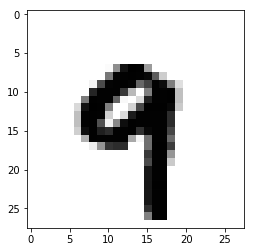

INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model3.1\model.ckpt-126082


In [84]:
plt.imshow(test[1729][0], cmap=cm.binary) # draw the picture
plt.show()
predicted_class =  []
input_fn = tf.estimator.inputs.numpy_input_fn(x={'x': test},num_epochs=1,
    shuffle=False)
for single_prediction in mnist_classifier.predict(input_fn):
    #print(single_prediction)
    predicted_class.append( single_prediction['classes'])
  
ids = np.array([x for x in range(1,28001)])
submission = pd.DataFrame({
        "ImageID": ids,
        "Label": predicted_class
    })
##print(submission)
submission.to_csv('NN3 126k steps.csv', encoding='utf-8', index=False)
